In [6]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')


In [7]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
import numpy as np
import pandas as pd
import random
import math
from utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree import Tree
import scipy.sparse as sp

In [8]:
data = pd.read_csv("/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/ml-1m/ratings.txt",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
random.seed(my_seed)
np.random.seed(my_seed)
# Iteratively filters out users and items with fewer than the threshold number of interactions until no changes happen.
data = threshold_interactions_df(data,'user_id','item_id',100,100)

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [9]:
all_user_ids = sorted(data['user_id'].unique())
warm_users = all_user_ids[:1414]
cold_users = all_user_ids[1414:]


df_warm = data[data['user_id'].isin(warm_users)].copy()
df_cold = data[data['user_id'].isin(cold_users)].copy()


In [10]:
matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating"
)


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix(
    df_cold, "user_id", "item_id", "rating"
)

In [11]:
al, train_cold_K, _ = train_test_split(matrix_cold, 1)


X_cold, test_cold, _ = train_test_split(al, 30)

In [ ]:
warm + cold split

## Approach 2
#### KX = sp.vstack([matrix_warm.copy() + train.copy() + X.copy()])

In [23]:
def elicitation_by_tree_path_retrain_depth_warm(
    
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    iteration=5
):
    """
    Method 2: Retrain tree each round using warm + cold user data.
    Walk i steps for each cold user to reach a node and elicit a new rating.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of warm, cold train and cold X
    KX = matrix_warm.copy() + train.copy() + X.copy()
    KX_copy = KX.tolil().copy()
    KX_df = matrix_to_df_2(KX_copy, idx_to_rid_cold, idx_to_cid)

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 5))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(KX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    

     # Step 1: Prepare tree training data (warm + updated cold)
    # warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
    # cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
    # x_df = pd.concat([warm_df, cold_df], ignore_index=False)

    # tree_model = tree_model_class(max_depth=i+1, min_instances=5)
    # tree_model.fit(x_df, x_df)


       

    return rmse_list, mae_list


In [25]:
def elicitation_by_tree_path_retrain_depth_warm(
    
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    iteration=5
):
    """
    Method 2: Retrain tree each round using warm + cold user data.
    Walk i steps for each cold user to reach a node and elicit a new rating.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of warm, cold train and cold X
    KX = train.copy() + X.copy()
    KX_copy = KX.tolil().copy()
    KX_df = matrix_to_df_2(KX_copy, idx_to_rid_cold, idx_to_cid)

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 5))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(KX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    

     # Step 1: Prepare tree training data (warm + updated cold)
    # warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
    # cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
    # x_df = pd.concat([warm_df, cold_df], ignore_index=False)

    # tree_model = tree_model_class(max_depth=i+1, min_instances=5)
    # tree_model.fit(x_df, x_df)


       

    return rmse_list, mae_list


In [26]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_2 =elicitation_by_tree_path_retrain_depth_warm(

    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    # iteration=8
)

RMSE: 0.8698
MAE:  0.6810
✅ Baseline evaluation complete.


## Approach 2
#### KX = train_cold_K + train_cold_X

In [ ]:
def elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class,
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    iteration=5
):
    """
    Method 2: Retrain tree each round using warm + cold user data.
    Walk i steps for each cold user to reach a node and elicit a new rating.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)

    # KX is the matrix of cold train and cold X
    KX = train.copy() + X.copy()
    KX_copy = KX.tolil().copy()
    KX_df = matrix_to_df_2(KX_copy, idx_to_rid_cold, idx_to_cid)

    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    reader = Reader(rating_scale=(1, 5))
    algo = SVD()
    KXtrainset = Dataset.load_from_df(KX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(KXtrainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (Tree depth = {i+1})")

        # Step 1: Prepare tree training data (warm + updated cold)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)

        tree_model = tree_model_class(max_depth=i+1, min_instances=5)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        # Step 2: Walk tree and elicit a new rating for each cold user
        for u in range(num_users):
            node = tree_model.root
            depth = 0

            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 4:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            if node is None or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                KX_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0

        # Step 3: Evaluate updated cold user SVD model
        KX_df = matrix_to_df_2(KX_copy, idx_to_rid_cold, idx_to_cid)
        algo = SVD()
        KXtrainset = Dataset.load_from_df(KX_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
        algo.fit(KXtrainset)

        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [13]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_2 =elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class=Tree,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=8
)

RMSE: 0.8715
MAE:  0.6822
✅ Baseline evaluation complete.

🔁 Iteration 1/8 (Tree depth = 1)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 0.8697
MAE:  0.6806
✅ Iteration 1 complete.

🔁 Iteration 2/8 (Tree depth = 2)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 0.8694
MAE:  0.6806
✅ Iteration 2 complete.

🔁 Iteration 3/8 (Tree depth = 3)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 0.8695
MAE:  0.6807
✅ Iteration 3 complete.

🔁 Iteration 4/8 (Tree depth = 4)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 0.8688
MAE:  0.6799
✅ Iteration 4 complete.

🔁 Iteration 5/8 (Tree depth = 5)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 0.8710
MAE:  0.6817
✅ Iteration 5 complete.

🔁 Iteration 6/8 (Tree depth = 6)
Initializing Splitter...
✅ C

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 0.8720
MAE:  0.6830
✅ Iteration 7 complete.

🔁 Iteration 8/8 (Tree depth = 8)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 0.8705
MAE:  0.6810
✅ Iteration 8 complete.


# Approach 3
## KX = warm + K_train_cold + K_train_X

In [ ]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(tree_model_class, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    # KX is the matrix of cold train and cold X
    KX = matrix_warm.copy() + train.copy() + X.copy()
    KX_copy = KX.tolil().copy()
    KX_df = matrix_to_df_2(KX_copy, idx_to_rid_cold, idx_to_cid) 

    # Step 0: Baseline evaluation
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(KX_df[['user_id', 'item_id', 'rating']], reader)
    SVDtrainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(SVDtrainset)
    
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    print("🔍 Evaluating baseline RMSE/MAE...")
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)} 
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")

        # Retrain tree using current train_copy
        tree_model = tree_model_class(max_depth=i + 1, min_instances=5)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = tree_model.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating >= 4:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    KX_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        KX_df = matrix_to_df_2(KX_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(KX_df[['user_id', 'item_id', 'rating']], reader)
        SVDtrainset = data_r.build_full_trainset()
        algo.fit(SVDtrainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_3 =elicitation_by_tree_path_retrain_skiped_warm(
    tree_model_class=Tree,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=6
)

In [17]:
def i_variance(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matirx):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()
    
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [18]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm, train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [21]:
entropy0 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    strategy=i_entropy_0,
    iteration=30,
    k=1,
    positive=False
)


RMSE: 1.6589
MAE:  1.4532
RMSE: 1.6291
MAE:  1.4257
1
RMSE: 1.5543
MAE:  1.3550
2
RMSE: 1.5552
MAE:  1.3552
3
RMSE: 1.5344
MAE:  1.3349
4
RMSE: 1.5073
MAE:  1.3089
5


KeyboardInterrupt: 

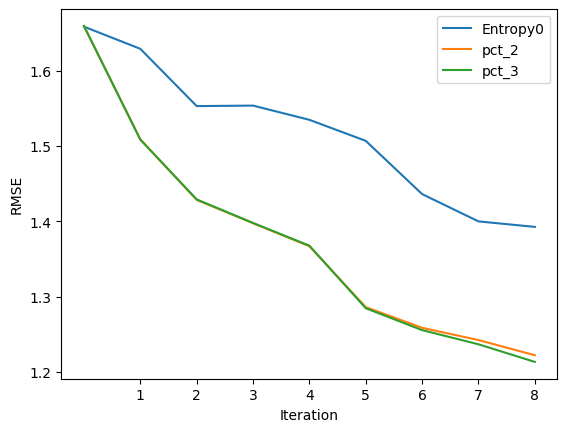

In [33]:
x = np.arange(0,9) 
fig, (ax1) = plt.subplots(1)
# fig.suptitle('Horizontally stacked subplots')
ax1.plot(x, entropy0[0], label='Entropy0')
# ax1.plot(x, helf_1[0], label='helf')
# ax1.plot(x, variance_1[0], label='variance')
ax1.plot(x, pct_2[0], label='pct_2')
ax1.plot(x, pct_3[0], label='pct_3')

plt.legend(loc=1)
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(1, 9)) 
plt.show()

# plt.xticks(x, list_i)

without warm and cold split

In [19]:
def elicitation_np(train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    
    train_copy = (train.tolil()).copy()

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        scores = strategy(train_copy)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [21]:
def revised_elicitation_by_tree_path(tree_model, train, test, X, idx_to_rid, idx_to_cid, iteration=5):
    """
    Elicitation using a trained PCT tree with fixed user paths based on the initial training data (train_static).
    Each user's path through the tree is determined only once, and revealed ratings are taken from X.
    This simulates a fixed-tree + fixed-path setting (non-personalized structure), while still retraining SVD with new ratings.

    Parameters:
    - tree_model: an untrained Tree model instance
    - train: sparse lil_matrix of initial ratings (used for tree + SVD initialization)
    - test: sparse lil_matrix for performance evaluation
    - X: full ground truth matrix (sparse lil_matrix) for simulating elicitation
    - idx_to_rid, idx_to_cid: mapping of matrix index to raw IDs
    - iteration: number of elicitation rounds (usually tree depth)

    Returns:
    - rmse_list, mae_list: error metrics at each iteration
    """
    from surprise import Dataset, Reader, SVD, accuracy
    from utils import matrix_to_df_2, matrix_to_full_df

    num_users, num_items = train.shape

    train_static = train.tolil().copy()  # Fixed source for tree/path decisions
    train_copy = train.tolil().copy()    # Updated training matrix for SVD
    X_copy = X.tolil().copy()            # For controlling repeated usage of ratings

    user_paths = {u: None for u in range(num_users)}
    rmse_list, mae_list = [], []

    # Step 1: Initial SVD performance evaluation
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    algo = SVD()
    algo.fit(Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset())

    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)

    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline performance computed.")

    # Step 2: Train the tree only once using train_static
    x_df = matrix_to_full_df(train_static, idx_to_rid, idx_to_cid)
    tree_model.fit(x_df, x_df)
    print("🌳 Tree training complete.")
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 3: Initialize user paths at tree root
    for u in range(num_users):
        user_paths[u] = tree_model.root

    # Step 4: Iterative elicitation (fixed path, dynamic ratings from X)
    for i in range(iteration):
        for u in range(num_users):
            node = user_paths[u]
            if node is None or node.is_leaf or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]

            # 1️⃣ Simulate path using static tree ratings
            rating_path = train_static[u, item_idx]

            # 2️⃣ Use actual ground truth rating from X to update training matrix
            rating_real = X_copy[u, item_idx]
            if rating_real > 0:
                train_copy[u, item_idx] = rating_real
                X_copy[u, item_idx] = 0  # prevent reuse

            # 3️⃣ Use static rating to decide user path
            if rating_path == 0:
                user_paths[u] = node.children[2]
            elif rating_path >= 4:
                user_paths[u] = node.children[0]
            else:
                user_paths[u] = node.children[1]

        # Step 5: Evaluate updated model
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        algo = SVD()
        algo.fit(Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset())

        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
        predictions = algo.test(testset)

        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1}/{iteration} complete.")

    return rmse_list, mae_list


In [23]:
def elicitation_by_tree_path_retrain_depth(tree_model_class, train, test, X, idx_to_rid, idx_to_cid, iteration=5):
    """
    Method 2 (final): Retrain tree each round, walk i steps based on train_copy ratings.
    Follow tree splits using 3-way logic (Lovers / Haters / Unknown).
    Ask the item at depth i if user reaches it.

    Parameters:
    - tree_model_class: class (not instance) of the tree model
    - train, test, X: lil_matrix
    - idx_to_rid, idx_to_cid: mapping of matrix index to raw ID
    - iteration: number of rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (train tree to depth {i+1})")

        # 1. Retrain tree with max_depth = i
        tree_model = tree_model_class(max_depth=i+1, min_instances=5)  # You can adjust min_instances
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        # 2. Walk tree and ask at depth i
        for u in range(num_users):
            node = tree_model.root
            depth = 0

            # Walk through tree using train_copy ratings
            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 4:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            # Ask item at depth i
            if node is None or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0  # Mark as asked

        # 3. Evaluate
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list




In [25]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped(tree_model_class, train, test, X, idx_to_rid, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")

        # Retrain tree using current train_copy
        tree_model = tree_model_class(max_depth=i + 1, min_instances=5)
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = tree_model.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating >= 4:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def elicitation_by_tree_path_retrain_depth_tree_only(
    tree_model_class, train, test, X,
    idx_to_rid, idx_to_cid, iteration=5
):
    """
    Method 4: Retrain tree each round, use tree for both Elicitation and Recommendation.

    Parameters:
    - tree_model_class: class of the tree model (not instance)
    - train, test, X: lil_matrix
    - idx_to_rid, idx_to_cid: mapping from matrix index to raw user/item id
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()  # updated
    X_copy = X.tolil().copy()          # unasked real rating
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    rmse_list = []
    mae_list = []

    # convert test set to DataFrame （NaN as untested）
    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_matrix = matrix_to_full_df(test, idx_to_rid, idx_to_cid)

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration}")

        # Step 1: Retrain tree using current train_copy
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model = tree_model_class(max_depth=i+1, min_instances=5)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree trained.")

        # Step 2: Elicit — ask each user the item at depth i
        for u in range(num_users):
            node = tree_model.root
            depth = 0

            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 4:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            if node is None or node.attribute_name is None:
                continue

            # Ask the item at current node
            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating  
                X_copy[u, item_idx] = 0           

        print("❓ Elicitation done. Now evaluating...")

        # Step 3: Predict all (user, item) in test set using the tree
        pred_matrix = tree_model.predict(test_matrix)

        y_true, y_pred = [], []

        for row in test_df.itertuples():
            uid, iid = row.user_id, row.item_id
            true_rating = row.rating
            pred_rating = pred_matrix.loc[uid, iid]

            if not pd.isna(pred_rating):
                y_true.append(true_rating)
                y_pred.append(pred_rating)

        rmse = mean_squared_error(y_true, y_pred, squared=False)
        mae = mean_absolute_error(y_true, y_pred)
        rmse_list.append(rmse)
        mae_list.append(mae)

        print(f"✅ Iteration {i+1} | RMSE: {rmse:.4f} | MAE: {mae:.4f}")

    return rmse_list, mae_list


In [29]:
def elicitation_p(train, test, X, tree_model, iteration, k, idx_to_rid, idx_to_cid):
    rmse, mae = [], []

    # Initial evaluation of the SVD recommender
    train_df = matrix_to_df_2(train, idx_to_rid, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)

    test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions = algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))

    # Initialization
    c_u_dict = {}
    all_items = list(range(0, train.shape[1]))
    X_matrix = (X.tolil()).copy()
    train_copy = (train.tolil()).copy()

    for count in range(iteration - 1):
        # Step 1: Convert to DataFrame and train the tree
        x_df = matrix_to_full_df(train_copy, idx_to_rid, idx_to_cid)
        tree_model.fit(x_df, x_df)

        # Step 2: Use the tree to predict ratings for unrated items
        pred_df = tree_model.predict_test(x_df)  # Same structure as x_df, values are predicted scores

        for u in range(train.shape[0]):
            if count == 0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items, p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()

            # Rank the predictions and select top-k
            pred_u = pred_df.iloc[u].to_dict()
            pred_dict = {i: pred_u[idx_to_cid[i]] for i in c_u}
            ranking_u = sorted(pred_dict.items(), key=lambda x: -x[1])
            topk_u = [item for item, _ in ranking_u[:k]]
            c_u_dict[u] = set_diff(c_u, topk_u)

            # Add items that the user has actually rated into train_copy
            px_u = X_matrix.getrow(u).nonzero()[1]
            recom = [item for item in topk_u if item in px_u]
            for item in recom:
                train_copy[u, item] = X[u, item]
                X_matrix[u, item] = 0

        # Step 3: Retrain SVD and record RMSE
        train_df = matrix_to_df_2(train_copy, idx_to_rid, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)

        test_df = matrix_to_df_2(test, idx_to_rid, idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions = algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))

        print(f"Iteration {count+1} done.")

    return rmse, mae


In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_4= elicitation_by_tree_path_retrain_depth_tree_only(Tree, train, test, X_matrix, idx_to_rid, idx_to_cid, iteration=8)



🔁 Iteration 1/8
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 1 | RMSE: 0.9964 | MAE: 0.7845

🔁 Iteration 2/8
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 2 | RMSE: 0.9987 | MAE: 0.7859

🔁 Iteration 3/8
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 3 | RMSE: 0.9944 | MAE: 0.7822

🔁 Iteration 4/8
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 4 | RMSE: 0.9923 | MAE: 0.7805

🔁 Iteration 5/8
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 5 | RMSE: 0.9859 | MAE: 0.7728

🔁 Iteration 6/8
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree trained.
❓ Elicitation done. Now evaluating...
✅ Iteration 6 | RMSE: 0.9795 | MAE: 0.7677

🔁 I

In [31]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_3 = elicitation_by_tree_path_retrain_skiped(Tree, train, test, X_matrix, idx_to_rid, idx_to_cid, iteration=8)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 1.1624
MAE:  0.9678
✅ Baseline evaluation complete.

🔁 Iteration 1/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.1004
MAE:  0.9178
✅ Iteration 1 complete.

🔁 Iteration 2/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.0808
MAE:  0.9009
✅ Iteration 2 complete.

🔁 Iteration 3/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.0676
MAE:  0.8866
✅ Iteration 3 complete.

🔁 Iteration 4/8 (skip asked items, walk from root)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.0605
MAE:  0.8771
✅ Iteration 4 complete.

🔁 Iteration 5/8 (skip asked items, walk from root)
Initializing Spl

In [33]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_2 = elicitation_by_tree_path_retrain_depth(Tree,train,test,X_matrix, idx_to_rid, idx_to_cid, iteration=8)


RMSE: 1.1622
MAE:  0.9678
✅ Baseline evaluation complete.

🔁 Iteration 1/8 (train tree to depth 1)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1009
MAE:  0.9184
✅ Iteration 1 complete.

🔁 Iteration 2/8 (train tree to depth 2)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0807
MAE:  0.9007
✅ Iteration 2 complete.

🔁 Iteration 3/8 (train tree to depth 3)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0672
MAE:  0.8865
✅ Iteration 3 complete.

🔁 Iteration 4/8 (train tree to depth 4)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0603
MAE:  0.8765
✅ Iteration 4 complete.

🔁 Iteration 5/8 (train tree to depth 5)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0560
MAE:  0.8700
✅ Iteration 5 complete.

🔁 Iteration 6/8 (train tree to depth 6)
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.0530
MAE:  0

In [29]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

tree = Tree(max_depth=7)
pct_1_2= revised_elicitation_by_tree_path(tree, train, test, X_matrix, idx_to_rid, idx_to_cid, iteration=8)


RMSE: 1.1624
MAE:  0.9678
✅ Baseline performance computed.
Initializing Splitter...
✅ Tree built successfully!
🌳 Tree training complete.
RMSE: 1.1004
MAE:  0.9178
✅ Iteration 1/8 complete.
RMSE: 1.0728
MAE:  0.8931
✅ Iteration 2/8 complete.
RMSE: 1.0589
MAE:  0.8694
✅ Iteration 3/8 complete.
RMSE: 1.0574
MAE:  0.8600
✅ Iteration 4/8 complete.
RMSE: 1.0553
MAE:  0.8578
✅ Iteration 5/8 complete.
RMSE: 1.0557
MAE:  0.8594
✅ Iteration 6/8 complete.
RMSE: 1.0577
MAE:  0.8481
✅ Iteration 7/8 complete.
RMSE: 1.0585
MAE:  0.8487
✅ Iteration 8/8 complete.


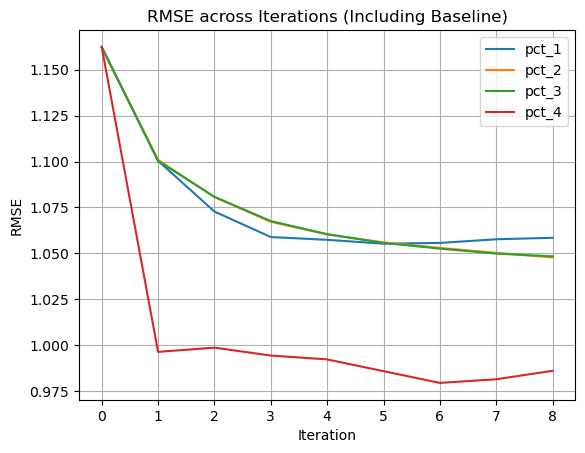

In [1]:
import numpy as np
import matplotlib.pyplot as plt


pct_1_rmse = [1.1624, 1.1004, 1.0728, 1.0589, 1.0574, 1.0553, 1.0557, 1.0577, 1.0585]
pct_2_rmse = [1.1622, 1.1009, 1.0807, 1.0672, 1.0603, 1.0560, 1.0530, 1.0503, 1.0478]
pct_3_rmse = [1.1624, 1.1004, 1.0808, 1.0676, 1.0605, 1.0557, 1.0526, 1.0499, 1.0484]
pct_4_rmse = [1.1624, 0.9964, 0.9987, 0.9944, 0.9923, 0.9859, 0.9795, 0.9815, 0.9861]

x = np.arange(0, 9)

fig, ax1 = plt.subplots()

ax1.plot(x, pct_1_rmse, label='pct_1')
ax1.plot(x, pct_2_rmse, label='pct_2')
ax1.plot(x, pct_3_rmse, label='pct_3')
ax1.plot(x, pct_4_rmse, label='pct_4')

plt.legend(loc='upper right')
plt.xlabel("Iteration")
plt.ylabel("RMSE")
plt.xticks(range(0, 9))
plt.title("RMSE across Iterations (Including Baseline)")
plt.grid(True)
plt.show()
